Import the libraries necessary to analize data

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('df_scaled.csv')

In [3]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'age_entropy_per_state',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'total_votes_for_state', 'involve_killing']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_participants_adult',
 'n_males',
 'n_females',
 'n_killed',
 'n_injured',
 'age_entropy_per_state',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'total_votes_for_state',
 'involve_killing',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [4]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

In [5]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   n_participants             197914 non-null  float64
 1   n_participants_child       197914 non-null  float64
 2   n_participants_teen        197914 non-null  float64
 3   n_participants_adult       197914 non-null  float64
 4   n_males                    197914 non-null  float64
 5   n_females                  197914 non-null  float64
 6   n_killed                   197914 non-null  float64
 7   n_injured                  197914 non-null  float64
 8   age_entropy_per_state      197914 non-null  float64
 9   n_arrested                 197914 non-null  float64
 10  n_unharmed                 197914 non-null  float64
 11  date                       197914 non-null  object 
 12  latitude                   197914 non-null  float64
 13  longitude                  19

# K-means

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

Knee Method to estimate the best K

In [7]:
k_grid = [2, 3, 4, 10, 100, 1000]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_numeric)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_

    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels

In [ ]:
for k in k_grid:
    print(f'for k = {k}')
    
    print('SSE %s' % dict_kmeans[f'{k}_sse']) # cohesion, lower value better clustering (error minimization)
    current_bouldin = metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin) # lower value, better clustering (minimum zero)
    
    current_silhouette = silhouette_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)

for k = 2
SSE 5.433117532775947e+17
Separation 0.4831899202222426
Silhouette 0.706216467148687
for k = 3
SSE 2.7925807755253475e+17
Separation 0.5474570149535806
Silhouette 0.5905545354560325
for k = 4
SSE 1.1054810130814395e+17
Separation 0.39862944063215855
Silhouette 0.641945720739745
for k = 10
SSE 1.129529229142226e+16
Separation 0.4560578404508913
Silhouette 0.6070019592063605
for k = 100
SSE 217180568490600.72
Separation 0.6173960401999775
Silhouette 0.5773484291106186
for k = 1000
SSE 306923566365.5127
Separation 0.15239830262413565
Silhouette 0.9681433719718947


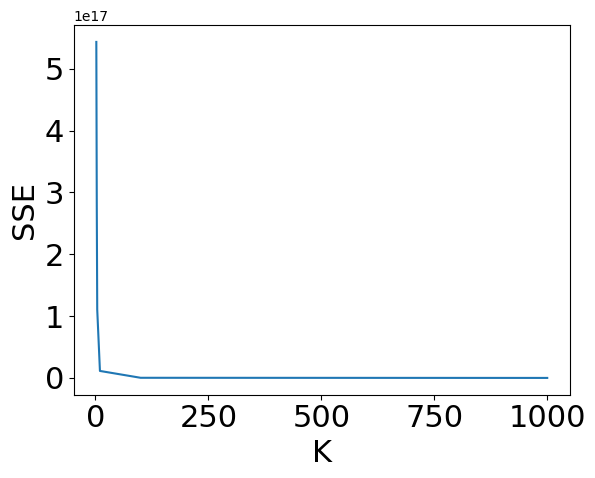

In [ ]:
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid,sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

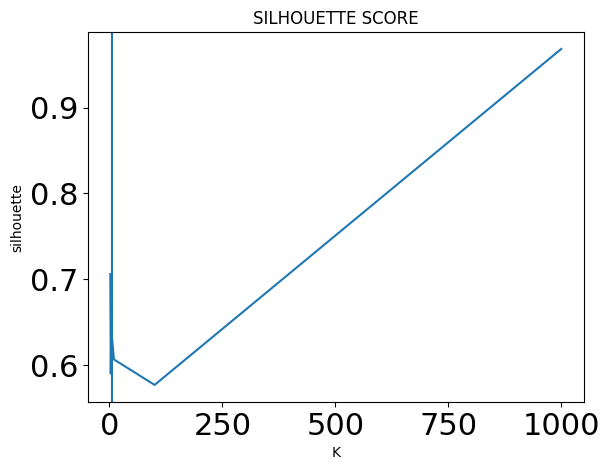

In [ ]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
#plt.axvline(6)
plt.show()

In [ ]:
#RETRAIN BEST K-MEANS
best_k = 2
best_kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=100)
best_kmeans.fit(df_numeric)

KMeans(max_iter=100, n_clusters=2, n_init=10)

In [ ]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [134353, 63561]


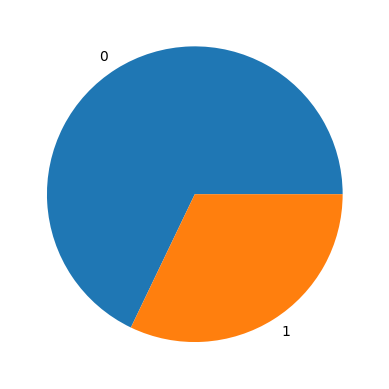

In [ ]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

In [ ]:
if 'labels' in df.columns:
    print('ok')
    del df['labels']
df['labels'] = pd.Series(best_kmeans.labels_,index=df.index)

In [ ]:
sns.pairplot(df,hue='labels', palette=sns.color_palette(n_colors=n_clusters))
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002588C0F6440> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}


for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[best_kmeans.labels_ == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)

#X_Means